# Assignment 1

# Density estimation using Real NVP

Normalizing flows is the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to train a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/2d-example.png)

#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution of $X$ by
<!-- \begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align} -->

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/f.png)
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density at a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
## $$y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big)$$

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: PyTorch, Numpy, sklearn, matplotlib.
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [185]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [442]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(torch.from_numpy(mask), requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        
        tensor_tmp = z.squeeze()
        for i in range(len(self.mask) - 1, -1, -1):
            tensor_tmp = self.mask[i].unsqueeze(axis=0) * tensor_tmp + (1 - self.mask[i]).unsqueeze(axis=0) * ((tensor_tmp - self.t[i](self.mask[i].unsqueeze(axis=0) * tensor_tmp)) * torch.exp(-1.0 * self.s[i](self.mask[i].unsqueeze(axis=0) * tensor_tmp)))
        return tensor_tmp.unsqueeze(axis=1)

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        tensor_tmp = x
        log_det_J = torch.full((x.shape[0],), 0.0)
        for i in range(len(self.mask)):
            s = self.s[i](self.mask[i].unsqueeze(axis=0) * tensor_tmp)
            tensor_tmp = self.mask[i].unsqueeze(axis=0) * tensor_tmp + (1 - self.mask[i]).unsqueeze(axis=0) * (tensor_tmp * torch.exp(s) + self.t[i](self.mask[i].unsqueeze(axis=0) * tensor_tmp))
            log_det_J += ((1 - self.mask[i]).unsqueeze(axis=0) * s).sum(axis=1)
        return tensor_tmp, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        
        samples = self.prior.sample(sample_shape=torch.Size([batchSize])).unsqueeze(axis=1)
        return self.g(samples)

In [443]:
class NeuralNetworkS(nn.Module):
    def __init__(self):
        super(NeuralNetworkS, self).__init__()
        fc1 = nn.Linear(2, 64)
        fc2 = nn.Linear(64, 128)
        fc3 = nn.Linear(128, 128)
        fc4 = nn.Linear(128, 64)
        fc5 = nn.Linear(64, 2)
        torch.nn.init.xavier_normal_(fc1.weight.data)
        torch.nn.init.xavier_normal_(fc2.weight.data)
        torch.nn.init.xavier_normal_(fc3.weight.data)
        torch.nn.init.xavier_normal_(fc4.weight.data)
        torch.nn.init.xavier_normal_(fc5.weight.data)
        self.pipeline = nn.Sequential(fc1, nn.Tanh(), fc2, nn.Tanh(), fc3, nn.Tanh(), fc4, nn.Tanh(), fc5, nn.Tanh())

    def forward(self, x):
        return self.pipeline(x)

In [444]:
class NeuralNetworkT(nn.Module):
    def __init__(self):
        super(NeuralNetworkT, self).__init__()
        fc1 = nn.Linear(2, 64)
        fc2 = nn.Linear(64, 128)
        fc3 = nn.Linear(128, 128)
        fc4 = nn.Linear(128, 64)
        fc5 = nn.Linear(64, 2)
        torch.nn.init.xavier_normal_(fc1.weight.data)
        torch.nn.init.xavier_normal_(fc2.weight.data)
        torch.nn.init.xavier_normal_(fc3.weight.data)
        torch.nn.init.xavier_normal_(fc4.weight.data)
        torch.nn.init.xavier_normal_(fc5.weight.data)
        self.pipeline = nn.Sequential(fc1, nn.Tanh(), fc2, nn.Tanh(), fc3, nn.Tanh(), fc4, nn.Tanh(), fc5, nn.Tanh())

    def forward(self, x):
        return self.pipeline(x)

In [445]:
from sklearn import datasets

In [446]:
noisy_moons = datasets.make_moons(n_samples=100, noise=.05)

In [447]:
nets = NeuralNetworkS
nett = NeuralNetworkT

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ❗️ Very important to make outputs of nets bounded due to exp (e.g. use nn.Tanh() as the last layer)
# ❗️ Don't be afraid to go too large, 3-4 not very small linear layers should work fine
# ❗️ Init of parameters matters, try different ones

In [448]:
import numpy as np
masks = np.array([[0.0, 1.0],
                  [1.0, 0.0], 
                  [0.0, 1.0], 
                  [1.0, 0.0], 
                  [0.0, 1.0], 
                  [1.0, 0.0], 
                  [0.0, 1.0],
                  [1.0, 0.0], 
                  [0.0, 1.0], 
                  [1.0, 0.0]]).astype(np.float32)
# masks = torch.Tensor of size #number_of_coupling_layers x #dim(X)
# number_of_coupling_layers like 6+ should works fine
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [449]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods

In [450]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.

In [451]:
flow.g(flow.f(torch.tensor([[5.0, 77.0], [0.0, 4.0]]))[0].unsqueeze(axis=1)).squeeze()

tensor([[5.0000e+00, 7.7000e+01],
        [1.0192e-07, 4.0000e+00]], grad_fn=<SqueezeBackward0>)

In [452]:
from sklearn import datasets

trainable_parametrs = flow.parameters()
optimizer = torch.optim.Adam(trainable_parametrs, lr=0.0001)

for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
    X = torch.Tensor(noisy_moons[0].astype(np.float32))
    loss = -flow.log_prob(X).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 504.602
iter 500: loss = 88.575
iter 1000: loss = 82.031
iter 1500: loss = 68.315
iter 2000: loss = 66.062
iter 2500: loss = 57.119
iter 3000: loss = 45.984
iter 3500: loss = 49.003
iter 4000: loss = 45.337
iter 4500: loss = 51.399
iter 5000: loss = 41.550


# Visualization

In [453]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

noisy_moons = datasets.make_moons(n_samples=100, noise=.05)

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

Text(0.5, 1.0, '$X = g(z)$')

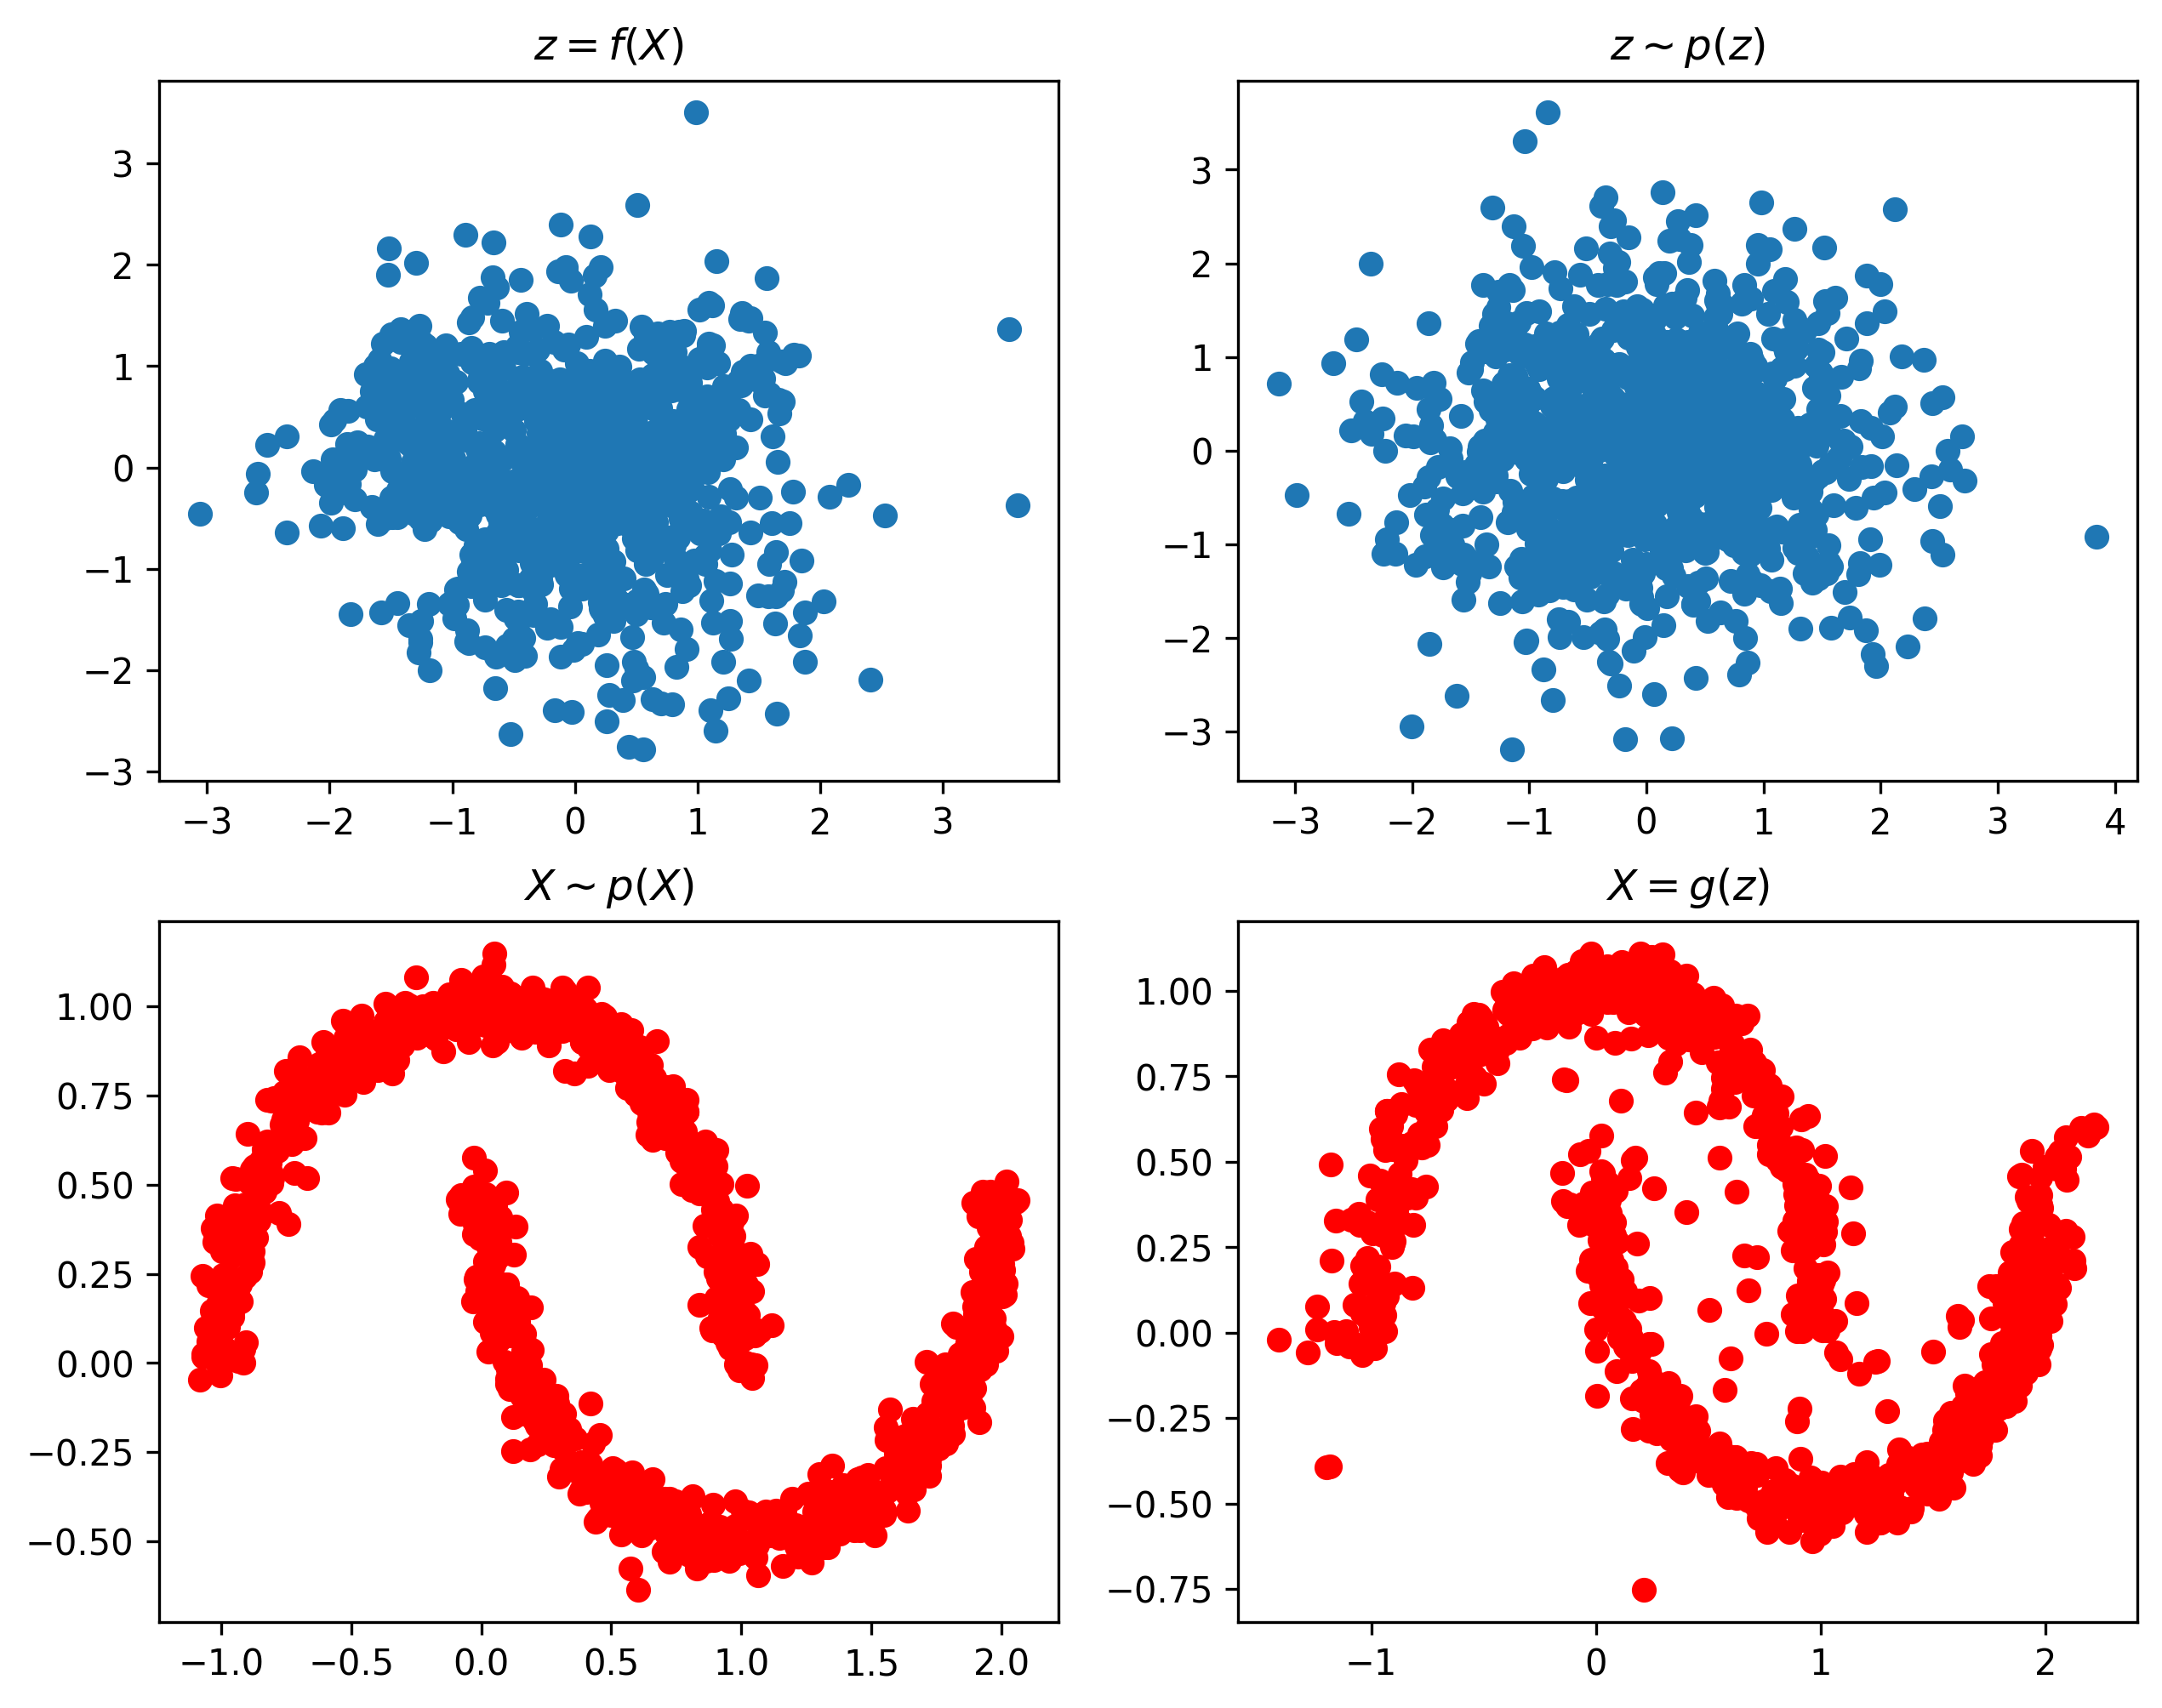

In [463]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Provide answers for the folowing questions:

1. What architecture worked better in your experiments?


Лучше всего работала архитектура нейросетей s и t состоящая из 5 линейных слоев (nn.Linear(2, 64), nn.Linear(64, 128), nn.Linear(128, 128), nn.Linear(128, 64), nn.Linear(64, 2)), где после каждого слоя следует функция активации гиперболического тангенса. Функции активации были выбраны исходя из соображений сочетания с экспонентой. Количество и ширина линейных слоев были подобраны экспериментально. Веса были инициализированы с помощью xavier_normal.

Было выбрано использовать 10 Coupling layers, массив масок состоит из чередующихся местами нуля и единицы (необходимо для равномерного преобразования обоих координат).

В качестве оптимизатора был выбран Adam.

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


Для стабильного и хорошего обучения важнее всего оказались функции активации (Tanh оказался лучше всех), начальная инициализация весов (xavier_normal) и количество Coupling layers (10 оптимальное значение).


3. How convergence speed (in iterations) depends on the complexity of architecture?


Скорость сходимости зависит от функций активации и начальной инициализации весов. Функция потерь лучше всего минимизируется с нейросетями выбранной архитектуры, для более простых или более сложных моделей функция потерь при обучении имеет большие значения.


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignments.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, then use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. More complex data: 
Train NFs for a more complex dataset e.g. MNIST (downscale is possible), make samples look reasonable e.g., solid fraction of samples can be recognized as a valid digits. Worth to use Conv2d layers for s and t.
